## Example: Stochastic modeling of the Fish Oxygen problem


We will use the fish-oxygen model from a prior homework for this example.  We will further assume that both flow rates and 


The conceptual model is:

    1. The pond is a “continuous flow, completely mixed” system – a fixed volume of water enters the pond each day, and the same volume leaves as effluent.  The volumetric flow rate is 2.0 L/L-day.  Initial Oxygen and Fish levels in the pond are 0.008 g/L and 1 g/L respectively.
    2. Oxygen level in the influent to the pond is 0.008 g/L
    3. Oxygen is consumed by fish at a rate proportionate to the biomass of Fish – each gram of Fish consumes 0.0012 grams of Oxygen per day.
    4. Fish grow according to exponential growth.  The per capita growth rate is 0.05/day.
    5.	Per-capita Fish mortality is an exponential function of Oxygen level, according to the following equation:
    
            `Per capita mortality = exp( -km * O2)`, where km  is a model parameter.

        
            
You will want to run the model for **60 days**

** Parameter Values: **

Parameter | Definition | Value
--------- | ---------- | -----
`O2in` | Oxygen level in pond influent | 0.008 g/L
`kO2` | Per-capita oxygen consumption rate | 0.0012 gO2/gFish-day
`kGrowth` | Per-capita growth rate of fish | 0.05 g/g-day
`km` | mortality rate parameter | 4700


## Step 1 - implement the model

success


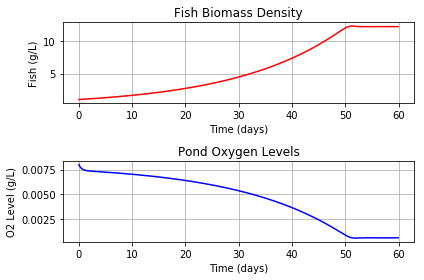

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# known model parameters.  Note: units are L, g, day
flowrate = 2     # L/L/day
kO2 = 0.0012     # gO2/gFish/ day
kGrowth = 0.05   # g/g/day
O2in = 0.008     # g/L
km = 4700        # 
aeration = 0.0   # g/L/day

FInit = 1
O2Init = 0.008

###### Fish/Oxygen model ######
def theModel(y,t):
    F = y[0]
    O2 = y[1]
    dF_dt  = kGrowth*F - np.exp(-km*O2) * F
    dO2_dt = flowrate*(O2in-O2) - (kO2*F) + aeration
    return [ dF_dt, dO2_dt]

def RunModel(times):
    Y = odeint( theModel, [FInit,O2Init], times)
    return Y

times = np.arange(0,60,0.1)
Y = RunModel(times)
F = Y[:,0]
O2 = Y[:,1]

print("success")
# lower plot - state variables through time
plt.subplot(2,1,1)
plt.plot(times, F, 'r-')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel( 'Fish (g/L)')
plt.title( 'Fish Biomass Density')
            
plt.subplot(2,1,2)            
plt.plot(times, O2, 'b-')
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel( 'O2 Level (g/L)')
plt.title( 'Pond Oxygen Levels')

plt.tight_layout()
plt.show()


## Examine flowrate, aeration rate data


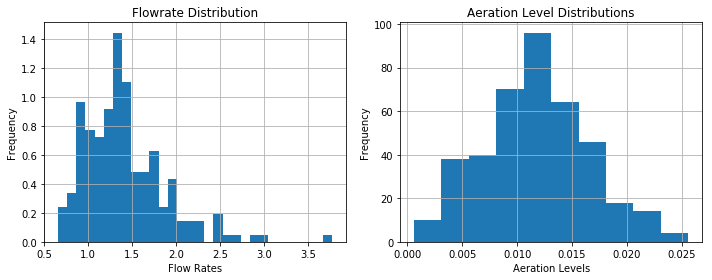

In [2]:
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm

# open the file
df = pd.read_excel( "http://explorer.bee.oregonstate.edu/topic/Modeling/data/MCFishOxygen.xlsx" )

# extract data
flows = df['flowrate']
aerations = df['aeration']


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(flows,normed=True,bins=30)
plt.grid()
plt.xlabel('Flow Rates')
plt.ylabel( 'Frequency')
plt.title( 'Flowrate Distribution')
            
plt.subplot(1,2,2)            
plt.hist(aerations,normed=True)
plt.grid()
plt.xlabel('Aeration Levels')
plt.ylabel('Frequency')
plt.title('Aeration Level Distributions')

plt.tight_layout()
plt.show()

## Generate probability distributions

In [3]:
from scipy.stats import norm
from scipy.stats import lognorm

# fit and freeze probability distributions
shape, loc, scale = lognorm.fit(flows, 0, loc=0, scale=0 )
pdFlows = lognorm(shape,loc=loc,scale=scale)
print( "Flows: shape=%.2f,  loc=%.1f,  scale=%.1f" % ( shape,loc,scale ) )

mean, stddev = norm.fit(aerations)
pdAerations = norm(loc=mean,scale=stddev)
print( "Aerations: mean=%.3f,  stddev=%.3f" % ( mean, stddev ) )

Flows: shape=0.46,  loc=0.4,  scale=0.9
Aerations: mean=0.012,  stddev=0.005



## Perform Monte Carlo Simulation

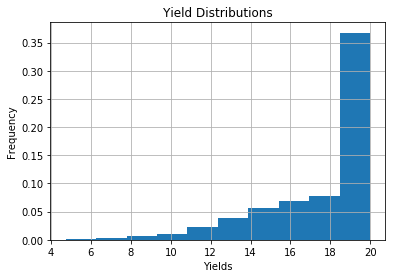

In [4]:
# Monte carlo:
count = 100
rvs_flowrate = pdFlows.rvs(size=count)
rvs_aeration = pdAerations.rvs(size=count)

Yields = np.zeros(count*count)

times = np.arange(0,60,0.1)
i = 0
for _f in rvs_flowrate:
    for _a in rvs_aeration:
        flowrate = _f
        aeration = _a
        
        Y = odeint( theModel, [FInit,O2Init], times)
        Yields[i] = Y[-1,0]
        i += 1

plt.hist(Yields,normed=True)
plt.grid()
plt.xlabel('Yields')
plt.ylabel( 'Frequency')
plt.title( 'Yield Distributions')
plt.show()

## Characterize output as probability distribution

/usr/local/lib/python3.5/dist-packages/scipy/stats/_continuous_distns.py:412: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


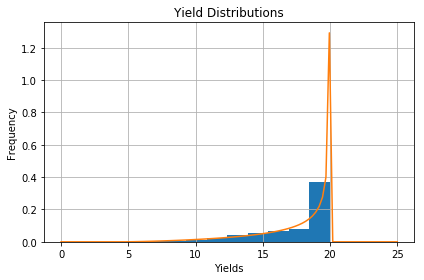

In [7]:
from scipy.stats import beta
        
# fit a weibull_max distribution
a,b,loc,scale = beta.fit(Yields)
pdYields = beta(a,b,loc=loc,scale=scale)

x = np.linspace(0,25,100)

plt.hist(Yields,normed=True)
plt.plot(x,pdYields.pdf(x))
plt.grid()
plt.xlabel('Yields')
plt.ylabel( 'Frequency')
plt.title( 'Yield Distributions')

plt.tight_layout()
plt.show()